<a href="https://colab.research.google.com/github/chen-star/llm_model_trainings/blob/main/train_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✈ Imports

In [1]:
# Core libs for numerical operations and plotting
import numpy as np
from typing import override
import matplotlib.pyplot as plt
import matplotlib as mpl

# Libraries for text processing
import requests
import re
import string

# PyTorch specific libraries
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

# External library for model summary and visualization
!pip install torchinfo # not installed by default in colab
from torchinfo import summary

# Matplotlib inline backend settings
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# huggingface
from datasets import load_dataset

# [0] 📁 Download Wiki Text and Tokenization

* Download dataset from huggingface dataset `Salesforce/wikitext`

* Sample 10k wiki text and tokenize to create vocabulary lookup-table.

In [2]:
ds = load_dataset("Salesforce/wikitext", "wikitext-103-v1")


README.md: 0.00B [00:00, ?B/s]

wikitext-103-v1/test-00000-of-00001.parq(…):   0%|          | 0.00/722k [00:00<?, ?B/s]

wikitext-103-v1/train-00000-of-00002.par(…):   0%|          | 0.00/156M [00:00<?, ?B/s]

wikitext-103-v1/train-00001-of-00002.par(…):   0%|          | 0.00/156M [00:00<?, ?B/s]

wikitext-103-v1/validation-00000-of-0000(…):   0%|          | 0.00/655k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [41]:
import re
import string

sample_size = 10000
all_text_sample = " ".join(ds['train']['text'][:sample_size])

# Split based on whitespace and punctuation
raw_words = re.split(r'[\s{}]+'.format(re.escape(string.punctuation)), all_text_sample)

# Filter out strings with length <= 1 and tokens with special characters
words = [
    word.strip().lower() for word in raw_words
    if len(word.strip()) > 1 and re.fullmatch(r'[a-zA-Z]+', word)
]

# Create vocabulary (unqiue set of words)
vocabulary = sorted(set(words))
numWords = len(words)
vocabulary_size = len(vocabulary)

# Encode / Decode tables. (Token_text <-> Token_ID)
token2id = {token: idx for idx, token in enumerate(vocabulary)}
id2Token = {idx : token for idx, token in enumerate(vocabulary)}


print(f'** This imported wiki dataset contains {numWords} words.')
print(f'** The vocabulary contains {vocabulary_size} unique words (tokens).\n')
print(f'** The first 10 words are: \n {list(words)[:10]} \n')
print(f'** The first 10 tokens are: \n {list(token2id.items())[:10]} \n')

** This imported wiki dataset contains 436368 words.
** The vocabulary contains 27991 unique words (tokens).

** The first 10 words are: 
 ['valkyria', 'chronicles', 'iii', 'no', 'valkyria', 'unk', 'chronicles', 'japanese', 'lit', 'valkyria'] 

** The first 10 tokens are: 
 [('aa', 0), ('aaa', 1), ('aadt', 2), ('aaj', 3), ('aak', 4), ('aaknal', 5), ('aamir', 6), ('aap', 7), ('aapke', 8), ('aaron', 9)] 



# [1] 🗄 Create Dataset and DataLoader

In [42]:
class TokenDataset(Dataset):
    def __init__(self, word_list, word_to_id, context_window_size=6, stride=4):
        self.word_to_id = word_to_id
        self.inputs = []
        self.targets = []

        # Example of how input and target sequences are formed:
        # Original text: "Training a toy embedding model requires data that is clean and rich in context"
        # If window_size is 6, stride is 4:
        # input[0]:  ["Training", "a", "toy", "embedding", "model", "requires"]
        # target[0]: ["a", "toy", "embedding", "model", "requires", "data"]
        # input[1]:  ["model", "requires", "data", "that", "is", "clean"]
        # target[1]: ["requires", "data", "that", "is", "clean", "and"]
        # ...

        # Iterate through the word list to create input-target pairs
        # The loop stops early to ensure a full window_size target sequence can be formed.
        for i in range(0, len(word_list) - context_window_size, stride):
          input_sequence_text = word_list[i : i + context_window_size]
          # shifted by one
          target_sequence_text = word_list[i + 1 : i + context_window_size + 1]

          input_sequence_ids = [word_to_id[word] for word in input_sequence_text]
          target_sequence_ids = [word_to_id[word] for word in target_sequence_text]

          self.inputs.append(torch.tensor(input_sequence_ids))
          self.targets.append(torch.tensor(target_sequence_ids))

    @override
    def __len__(self):
      """Returns the total number of input-target pairs in the dataset."""
      return len(self.inputs)

    @override
    def __getitem__(self, index):
        """Returns the input and target tensors for a given index."""
        return self.inputs[index], self.targets[index]

# Initialize the dataset using the cleaned 'words' list and the 'token2id' mapping
wiki_text_dataset = TokenDataset(word_list=words, word_to_id=token2id, context_window_size=6, stride=3)

# Example: Retrieve the last item from the dataset
wiki_text_dataset[-1]

(tensor([19445, 17353, 25284, 25098, 19780, 13079]),
 tensor([17353, 25284, 25098, 19780, 13079,  7448]))

In [43]:
batch_size = 2 # 2 is easy for viewing the training process

dataloader = DataLoader(
      wiki_text_dataset,
      batch_size=batch_size,
      shuffle=True,   # shuffle each epoch
      drop_last=True, # drop incomplete batch
    )

# View inputs and targets
first_batch_inputs, first_batch_targets = next(iter(dataloader))
print(f'** 1st batch inputs shape: {first_batch_inputs.shape}, targets shape: {first_batch_targets.shape}')
print(f'** 1st input in 1st batch: \n {first_batch_inputs[0]}. ')
print(f'** 1st input in 1st batch: \n {first_batch_inputs[0]} = {[id2Token[t.item()] for t in first_batch_inputs[0]]} ')
print(f'** 1st target in 1st batch: \n {first_batch_targets[0]} = {[id2Token[t.item()] for t in first_batch_targets[0]]}')

** 1st batch inputs shape: torch.Size([2, 6]), targets shape: torch.Size([2, 6])
** 1st input in 1st batch: 
 tensor([11862,  6755,  2287, 23689, 11045, 14240]). 
** 1st input in 1st batch: 
 tensor([11862,  6755,  2287, 23689, 11045, 14240]) = ['hospitals', 'developed', 'because', 'staff', 'had', 'left'] 
** 1st target in 1st batch: 
 tensor([ 6755,  2287, 23689, 11045, 14240,  9714]) = ['developed', 'because', 'staff', 'had', 'left', 'for']


# [2] 🔶 Define Embedding Layer

In [44]:
# Define embedding matrix dimension
R_embedding = vocabulary_size
embedding_dimension = 128
C_embedding = embedding_dimension # arbitrarily set to 128

embedding_layer = nn.Embedding(R_embedding, C_embedding)

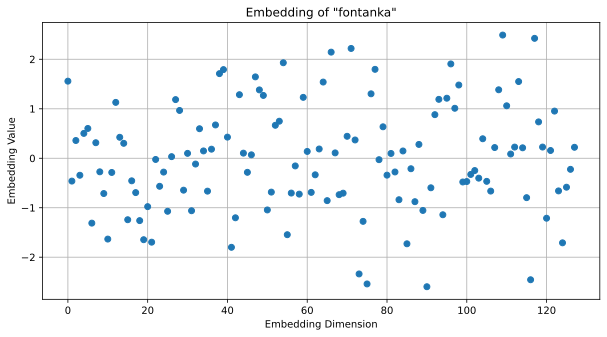

In [45]:
# View the Embedding for a random token.

randomToken = np.random.choice(vocabulary)

# Get the ID of the random token
token_id = token2id[randomToken]

# Get the embedding vector for the token without forward pass
embedding_vector = embedding_layer.weight.detach()[token2id[randomToken],:]

# Convert to numpy for plotting
embedding_values = embedding_vector.numpy()

# Plot the embedding vector as unconnected dots
plt.figure(figsize=(10, 5))
plt.plot(embedding_values, 'o')
plt.xlabel('Embedding Dimension')
plt.ylabel('Embedding Value')
plt.title(f'Embedding of "{randomToken}"')
plt.grid(True)
plt.show()

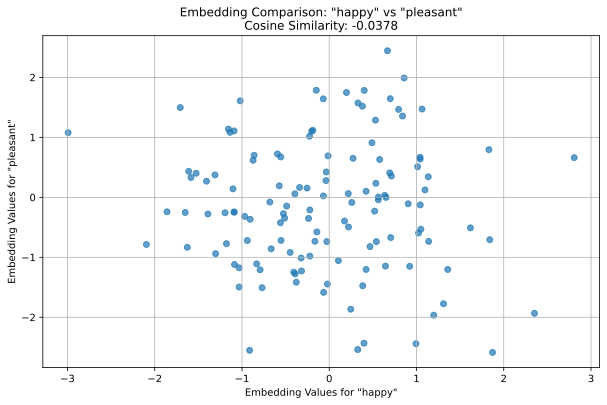

In [46]:
# View the Embedding for 2 semantically close tokens.
token_1 = "happy"
token_2 = "pleasant"

embedding_vector_1 = embedding_layer.weight.detach()[token2id[token_1],:]
embedding_vector_2 = embedding_layer.weight.detach()[token2id[token_2],:]

# cosine similarity
cosine_similarity = torch.dot(embedding_vector_1, embedding_vector_2) / (torch.norm(embedding_vector_1) * torch.norm(embedding_vector_2))


# Plotting embedding_vector_1 as x and embedding_vector_2 as y
plt.figure(figsize=(10, 6))
plt.scatter(embedding_vector_1.numpy(), embedding_vector_2.numpy(), alpha=0.7)
plt.xlabel(f'Embedding Values for "{token_1}"')
plt.ylabel(f'Embedding Values for "{token_2}"')
plt.title(f'Embedding Comparison: "{token_1}" vs "{token_2}"\nCosine Similarity: {cosine_similarity:.4f}')
plt.grid(True)
plt.show()

# [3] 🔷 Define the Model

In [54]:
class EmbeddingModel(nn.Module):
  def __init__(self, vocabulary_size, embedding_dimension, context_window_size):
    super(EmbeddingModel, self).__init__()

    # embedding layer
    self.embedding_layer = nn.Embedding(vocabulary_size, embedding_dimension)
    # hidden layer
    self.hidden_layer = nn.Linear(context_window_size * embedding_dimension,256)
    # output layer
    self.output_layer = nn.Linear(256, vocabulary_size)

  @override
  def forward(self, inputs):
    # Apply embedding layer to inputs
    embedded_inputs = self.embedding_layer(inputs)
    # Flatten the embedded inputs: (batch_size, context_window_size * embedding_dimension)
    flattened_inputs = embedded_inputs.view(embedded_inputs.size(0), -1)

    # Pass through hidden layer with ReLU activation
    hidden_output = F.relu(self.hidden_layer(flattened_inputs))

    # Pass through output layer
    output = self.output_layer(hidden_output)
    # Apply log_softmax to the output for NLLLoss
    log_probs = F.log_softmax(output, dim=1)
    return log_probs

model = EmbeddingModel(
    vocabulary_size=vocabulary_size,
    embedding_dimension=embedding_dimension,
    context_window_size=6,
)
model

EmbeddingModel(
  (embedding_layer): Embedding(27991, 128)
  (hidden_layer): Linear(in_features=768, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=27991, bias=True)
)

In [58]:
# Test the model with 1st batch of dataset
first_batch_inputs, first_batch_targets = next(iter(dataloader))

# The model predicts one next word for each input sequence in the batch.
# We get the log-probabilities for the first sequence in the batch, find the token ID
# with the highest probability (argmax), and convert it to a Python scalar (.item()).
predicted_token_id_for_first_input = model(first_batch_inputs)[0].argmax().item()

# Corrected printing for inputs: Iterate over individual token IDs within the first sequence
print(f'** Inputs (first sequence): {[id2Token[token_id.item()] for token_id in first_batch_inputs[0]]}')

# Corrected printing for targets: Iterate over individual token IDs within the first target sequence
# (Note: The model currently predicts a single word, while the target is a sequence of 6 words.)
print(f'** Targets (first sequence): {[id2Token[token_id.item()] for token_id in first_batch_targets[0]]}')

# Corrected printing for outputs: predicted_token_id_for_first_input is already a scalar
print(f'** Predicted Output (for first input sequence): {id2Token[predicted_token_id_for_first_input]}')

** Inputs (first sequence): ['or', 'critiqued', 'as', 'legitimate', 'book', 'the']
** Targets (first sequence): ['critiqued', 'as', 'legitimate', 'book', 'the', 'book']
** Predicted Output (for first input sequence): teaching


In [67]:
summary(model, input_data=first_batch_inputs, verbose=1, col_names=("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
EmbeddingModel                           [2, 6]                    [2, 27991]                --
├─Embedding: 1-1                         [2, 6]                    [2, 6, 128]               3,582,848
├─Linear: 1-2                            [2, 768]                  [2, 256]                  196,864
├─Linear: 1-3                            [2, 256]                  [2, 27991]                7,193,687
Total params: 10,973,399
Trainable params: 10,973,399
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 21.95
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 43.89
Estimated Total Size (MB): 44.36


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
EmbeddingModel                           [2, 6]                    [2, 27991]                --
├─Embedding: 1-1                         [2, 6]                    [2, 6, 128]               3,582,848
├─Linear: 1-2                            [2, 768]                  [2, 256]                  196,864
├─Linear: 1-3                            [2, 256]                  [2, 27991]                7,193,687
Total params: 10,973,399
Trainable params: 10,973,399
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 21.95
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 43.89
Estimated Total Size (MB): 44.36

# [4] Model Training

#### Some pre-work befor training...

In [68]:
# Update the DataLoader batch size to 32
batch_size = 32

dataloader = DataLoader(
      wiki_text_dataset,
      batch_size=batch_size,
      shuffle=True,   # shuffle each epoch
      drop_last=True, # drop incomplete batch
    )

In [69]:
# Switch to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu
